# JWST PSF Subtraction Using in-flight Simulations
One common application of accurate simulations is to perform a PSF subtraction in order to reveal details about, for example, extended emission surrounding a point source.

This notebook demonstrates such a PSF subtraction as as example for making PSF simulations matched to a particular science observation. 

<div class="alert alert-block alert-info">

To make simulated PSFs a closer match to data "right out of the box", STPSF as of release 1.2 includes  simplified models to add significant detector effects into simulated PSFs for NIRCam, NIRISS, and MIRI. 
</div>

In [1]:
import photutils
import stpsf
import matplotlib.pylab as plt
from astropy.nddata import Cutout2D
from astropy.visualization import simple_norm

## Retrieve and load an example image 

Let's define a simple function to download images from the [MAST portal](https://mast.stsci.edu/). Note that in order to use this function you need to know the file name of the relevant observation.  

In [2]:
def mast_retrieve_files(filename, output_path=None, verbose=False, redownload=False, token = None):
    """Download files from MAST.
    If file is already present locally, the download is skipped and the cached file is used.
    """
    import os
    from requests.exceptions import HTTPError
    from astroquery.mast import Mast
    if token:
        Mast.login(token = token)

    if output_path is None:
        output_path = '.'
    else:
        output_path = output_path

    output_filename = os.path.join(output_path, filename)

    if not os.path.exists(output_path):
        os.mkdir(output_path)

    if os.path.exists(output_filename) and not redownload:
        if verbose:
            print(f"Found file previously downloaded: {filename}")
        return output_filename
    
    data_uri = f'mast:JWST/product/{filename}'

    # Download the file
    url_path = Mast._portal_api_connection.MAST_DOWNLOAD_URL
    try:
        Mast._download_file(url_path + "?uri=" + data_uri, output_filename)
    except HTTPError as err:
        print(err)
#mast:JWST/product/jw01163174001_03102_00001_nrca3_uncal.fits
    return output_filename


In this example, we are going to use a NIRCam LW observation (F356W) from the Wavefront Sensing Maintenance program, PID 2725, observation 484. All observations from the wavefront sensing maintenance program are publicly available to the scientific community. 

Let's display and examine this particular observation. 

In [3]:
file = 'jw02725-o484_t097_nircam_clear-f356w-nrcalong_wfscmb-04.fits'
mast_retrieve_files(file)

'./jw02725-o484_t097_nircam_clear-f356w-nrcalong_wfscmb-04.fits'

In [4]:
# Open and inspect observation
from astropy.io import fits 
from photutils.background import Background2D, MedianBackground
from astropy.stats import SigmaClip
from photutils.detection import IRAFStarFinder


psf = fits.open(file)
data = psf['SCI'].data
mask = (psf['DQ'].data % 2).astype('bool')
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
#norm = simple_norm(data1,  'log',min_cut = min_cut, max_cut = max_cut )
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                       sigma_clip=sigma_clip, bkg_estimator=bkg_estimator, mask = mask)

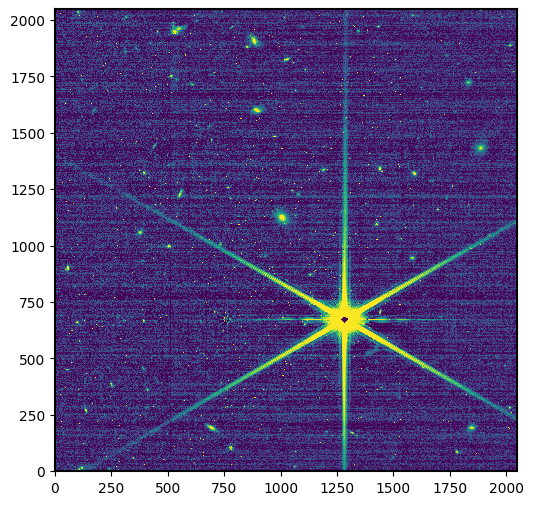

In [5]:
plt.figure(figsize = (6,6))
norm = simple_norm(data - bkg.background,  'asinh', min_percent = 20, max_percent=98.99 )
plt.imshow(data - bkg.background, norm = norm , origin = 'lower', cmap='viridis')

This  observation is dominated by a bright saturated PSF which corresponds to a calibration star. However, note that in the background there are many galaxies and, in particular, there is a galaxy merger close to a point source in the upper-left part of this image, around pixels (550, 1950). 


Let's zoom-in around that location:

## Extract a subarray around a particular source of interest, and measure source location


In [6]:
position = (550, 1950)    # approximate location. This will be improved below. 
size_pixels = 200         # size of subarray to use

Text(0.5, 1.0, 'Cutout around a galaxy merger and a star')

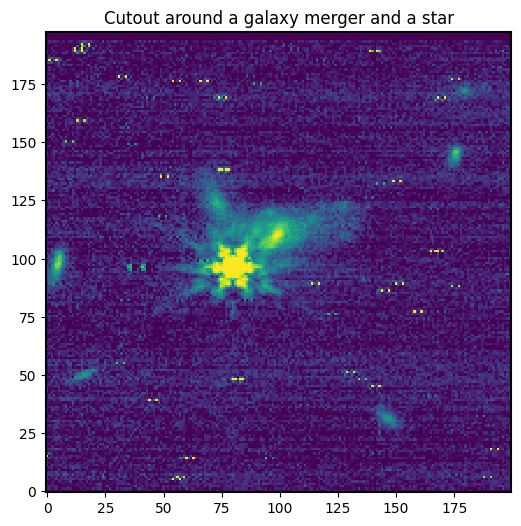

In [7]:
data_source = Cutout2D(data - bkg.background, position, size_pixels).data
plt.figure(figsize = (6,6))
norm = simple_norm(data_source,  'asinh',min_percent=20, max_percent=99.6 )
plt.imshow(data_source, norm = norm , origin = 'lower', cmap='viridis')
plt.title("Cutout around a galaxy merger and a star")

In the image above we can identify what appears to be a galaxy merger with a close by bright PSF. In this example, we are using this system as our science case in order to perform a PSF subtraction and to gain information about the extended emission surrounding these galaxies. 


Note that the particular reduction steps applied to this calibration exposure did not include rejection of outlier "hot" pixels, which can be seen scattered around the image. Different reduction steps would be typically applied for science data. However, for demonstration purposes here we can simply ignore those hot pixels and demonstrate how to model and subtract out the stellar PSF visible there. 

We start by finding the location of our bright PSF:

In [8]:
starfind = IRAFStarFinder(fwhm=3.0, threshold=100.*bkg.background_median) 
sources = starfind(data_source) 

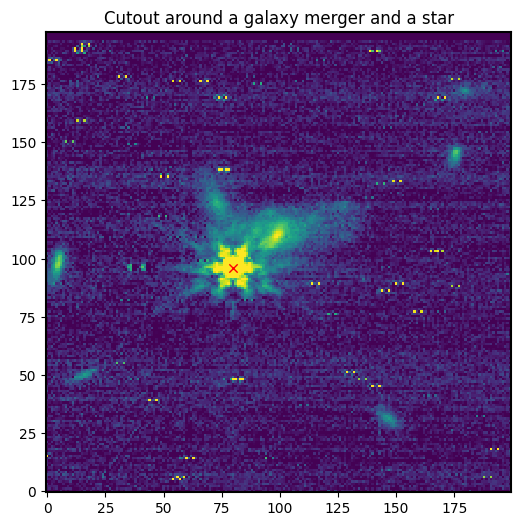

In [9]:
plt.figure(figsize = (6,6))
plt.imshow(data_source, norm = norm , origin = 'lower', cmap='viridis')
plt.title("Cutout around a galaxy merger and a star")
plt.scatter(sources['xcentroid'], sources['ycentroid'], color='red', marker='x')

In this table, `xcentroid` and `ycentroid` are positions of the source relative to the cutout image. Sometime it is important to have the position in the frame of reference of the original image. 

In [10]:
positions_original = Cutout2D(data - bkg.background, position, size_pixels).to_original_position((sources['xcentroid'],sources['ycentroid']))

Then we can re-center our cutout image around this PSF. 

Text(0.5, 1.0, 'Cutout centered on the star')

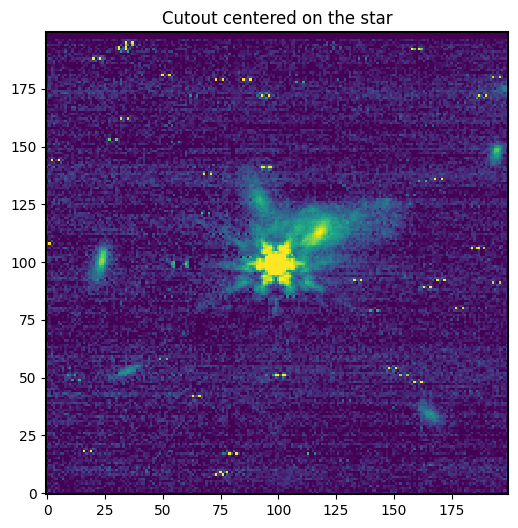

In [11]:
position = (positions_original[0].value[0], positions_original[1].value[0])
size = 200
data_source = Cutout2D(data - bkg.background, position, size_pixels).data

plt.figure(figsize = (6,6))
norm = simple_norm(data_source,  'asinh',min_percent=20, max_percent=99.6 )
plt.imshow(data_source, norm = norm , origin = 'lower', cmap='viridis')
plt.title("Cutout centered on the star")

We can express the position of the source in the data frame of the original image. This position is going to help us set up our STPSF simulations. 

In [12]:
position

(530.024178293244, 1946.067039647067)

## Generate STPSF Simulation to match that JWST observation
Here we use a convinient function [`stpsf.setup_sim_to_match_file`](https://stpsf.readthedocs.io/en/latest/jwst_matching_psfs_to_data.html) in order to setup our STPSF simulation as close as possible to the optical performnace of JWST at the time of the observation. Note that we are also adding the position of our observed PSF to the simulation via [`detector_position`](https://stpsf.readthedocs.io/en/latest/api/stpsf.SpaceTelescopeInstrument.html#stpsf.SpaceTelescopeInstrument.detector_position)

In [13]:
inst = stpsf.setup_sim_to_match_file(file)
inst.detector_position = position

single_stpsf_nrc = inst.calc_psf(fov_pixels=size_pixels)

Setting up sim to match jw02725-o484_t097_nircam_clear-f356w-nrcalong_wfscmb-04.fits
iterating query, tdelta=3.0

MAST OPD query around UTC: 2022-11-29T17:26:06.893
                        MJD: 59912.72646866898

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022112903-NRCA3_FP1-1.fits
	Date (MJD):	 59912.7265
	Delta time:	 -0.0000 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022120203-NRCA3_FP1-1.fits
	Date (MJD):	 59915.1683
	Delta time:	 2.4418 days
User requested choosing OPD time closest in time to 2022-11-29T17:26:06.893, which is R2022112903-NRCA3_FP1-1.fits, delta time -0.000 days
Importing and format-converting OPD from /Users/mperrin/software/stpsf-data/MAST_JWST_WSS_OPDs/R2022112903-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point

Configured simulation instrument for:
    Instrument: NIRCam
    Filter: F356W
    Detector: NRCA5
    Apername: NRCA5_FULL
    Det. Pos.: (1024,

## Scale and subtract the PSF model from the data

We'll use [photutils](https://photutils.readthedocs.io/) to fit and subtract the PSF from the data. First, we take the output simulated PSF and convert it into a photutils fittable model:

In [14]:
stpsf_model = photutils.psf.FittableImageModel(single_stpsf_nrc['DET_DIST'].data, normalize=True, oversampling=1)

Let's use [`PSFPhotometry`](https://photutils.readthedocs.io/en/stable/api/photutils.psf.PSFPhotometry.html#photutils.psf.PSFPhotometry) in order to subtract our STPSF model from the observation

In [15]:
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry
fit_shape = (5, 5)
psfphot = PSFPhotometry(stpsf_model, fit_shape, finder=starfind,
                        aperture_radius=4)

# fit model PSF to background subtracted data
phot = psfphot(data_source)

In [16]:
print(phot) #single source

 id group_id local_bkg      x_init          y_init         flux_init           x_fit             y_fit       ...        y_err             flux_err     npixfit group_size         qfit                 cfit         flags
--- -------- --------- --------------- --------------- ------------------ ---------------- ----------------- ... ------------------- ----------------- ------- ---------- ------------------- --------------------- -----
  1        1       0.0 99.024178293244 99.067039647067 3328.1781920824656 99.0218190151787 99.07262068166906 ... 0.02463645064189353 75.75458090882374      25          1 0.08165903959838369 -0.012449800305229235     0




After a successful PSF fit then we can create a residual image



In [17]:
residual =  psfphot.make_residual_image(data_source, (size_pixels, size_pixels))

Finally, we can inspect the before and after the PSF subtraction. 

Text(0.5, 1.0, 'Clean - PSFPhotometry zoom')

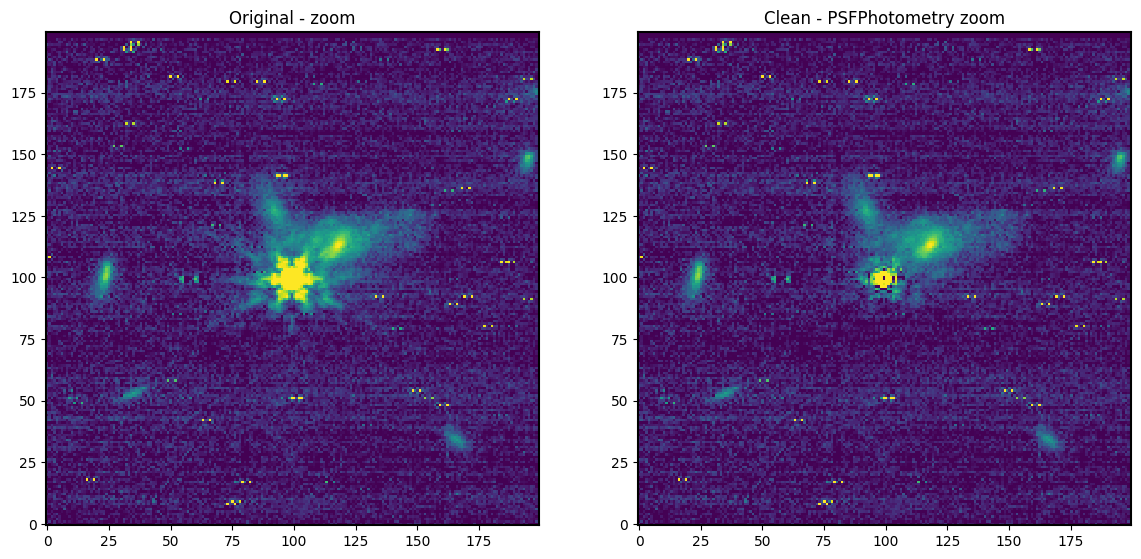

In [18]:
plt.figure(figsize = (14,16))

plt.subplot(1,2,1)
plt.imshow(data_source, norm = norm , origin = 'lower', cmap='viridis')
plt.title('Original - zoom')

plt.subplot(1,2,2)
plt.imshow(residual, norm = norm , origin = 'lower', cmap='viridis')
plt.title('Clean - PSFPhotometry zoom')

The final "clean" image looks good with most of the PSF diffraction spikes successfully removed thus presenting a better visual characterization of our example case of galaxy mergers.

In this example, we show one possible way to perform PSF subtraction by using STPSF "right out of the box" simuation. However, it is possible to fine-tuned some of these effects, in particular, charge diffusion to better match the observations. See [JWST Implementing Detector Effects in Simulations](https://stpsf.readthedocs.io/en/latest/jwst_detector_effects.html#JWST-Implementing-Detector-Effects-in-Simulations)

There are more specialized algorithms for PSF subtraction available elsewhere, especially for high contrast and/or coronagraphic science cases. This is intentionally a simple example for how to create a simulatd PSF for a particular data file.